## Lista 2 - Aprendizagem de máquina probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Modelos

### Regressão linear bayesiana

#### Estimação 
1. Definir, a partir de conhecimentos anteriores, momentos da priori $p(w) = \mathcal{N}(w|m_0,S_0)$ e a variância do ruído, $p(\epsilon) = \mathcal{N}(\epsilon|0, \sigma^2)$

2. A partir de $\mathcal{D}=(X,y)$, calcular a posteriori de w
    - $P(w|D) = \mathcal{N}(w|\mu,\Sigma)$, em que
    - $\mu = m_0 + (S_0 X^T+ \sigma^2I)^{-1}S_0X^T(y-X m_0)$ 
    - $\Sigma = S_0 - (S_0 X^T X + \sigma^2 I)^{-1} S_0 X^T X S_0$
3. Retornar a posteriori dos parâmetros $p(w|D)$

#### Predição
1. A partir dos dados $X_{\ast} \in \mathbb{R}^{(N_{\ast} \times D)}$, retornar a distribuição 

$$p(y_{\ast}| X_{\ast}) = \mathcal{N}(y_{\ast}|X_{\ast}\mu, X_{\ast} \Sigma X_{\ast}^T + \sigma^2I)$$


In [110]:
class BayesianLinReg():
    def __init__(self, sigma2,m0,s0):
        self.sigma2 = sigma2
        self.m0 = m0
        self.s0 = s0 
        
    def estimate(self, X, y):
        s0_inv = np.linalg.inv(self.s0)
        Sigma_inv = s0_inv + (1 / self.sigma2) * (X.T @ X)
        self.Sigma = np.linalg.inv(Sigma_inv)
        self.mu = self.Sigma @ (s0_inv @ self.m0 + (1 / self.sigma2) * X.T @ y)
        posteriori = np.random.multivariate_normal(self.mu.flatten(), self.Sigma)
        return posteriori

    def predict(self, X_ast):
        media = (X_ast @ self.mu).flatten()
        var = X_ast @ self.Sigma @ X_ast.T + (self.sigma2 * np.eye(X_ast.shape[0]))

        predictions = np.random.multivariate_normal(media, var)
        return predictions

### Regressão Polinomial Bayesiana

As expressões do modelo continuam as mesmas.
As mudanças são que, agora temos,

$$\Phi = \phi(X) = [\phi(x_1), \phi(x_2), \cdots, \phi(x_N)]^T$$
em que $\phi(x_i) = [1,x_i, x_i^2, \cdots, x_i^P]^T$, onde $P$ é a ordem do polinômio desejado

E com isso nosso $y$ será definido por $y= \Phi w + \epsilon$. Dessa forma o cálculo de $\mu$ e $\Sigma$ seram dados por 

- $\mu = m_0 +(S_0 \Phi^T \Phi + \sigma^2I)^{-1}S_0 \Phi^T (y - \Phi m_0) $  
- $\Sigma = S_0 +(S_0 \Phi^T \Phi + \sigma^2I)^{-1}S_0 \Phi^T \Phi S_0$

E a nossa predição é dada por 

$$p(y_\ast| X_\ast, \mathcal{D}, m_0, S_0, \sigma^2) = \mathcal{N}(y_\ast|\Phi_\ast \mu , \Phi_\ast \Sigma \Phi_\ast^T + \sigma^2I)$$

In [111]:
class BayesianPolyReg():
    def __init__(self, sigma2, m0, s0, degree):
        self.sigma2 = sigma2
        self.m0 = m0
        self.s0 = s0
        self.degree = degree
    
    def elevate(self, X: pd.DataFrame):
        x_vals = X.values.flatten()  
        Phi = np.vstack([x_vals**d for d in range(self.degree + 1)]).T        
        return Phi

    def estimate(self, X, y):
        Phi = self.elevate(X)
        y = y.values.reshape(-1,1) 
        
        s0_inv = np.linalg.inv(self.s0)
        Sigma_inv = s0_inv + (1 / self.sigma2) * (Phi.T @ Phi)  
        self.Sigma = np.linalg.inv(Sigma_inv)
        
        self.mu = self.Sigma @ (s0_inv @ self.m0 + (1 / self.sigma2) * Phi.T @ y)
        
        posteriori  = np.random.multivariate_normal(self.mu.flatten(), self.Sigma)
        return posteriori

    
    def predict(self, X_ast):
        # fazer a transformacao do X_ast em Phi_ast
        Phi_ast = self.elevate(X_ast)
        media = (Phi_ast @ self.mu).flatten()
        var = Phi_ast @ self.Sigma @ Phi_ast.T + (self.sigma2 * np.eye(Phi_ast.shape[0]))

        predictions = np.random.multivariate_normal(media, var)
        return predictions

### Regressão logística IRLS

#### Estimação
1. Definir, a partir de conhecimentos anteriores, os momentos da priori $p(w) = \mathcal{N}(w|m_0,S_0)$ e o valor inicial de $m_0 \in \mathbb{R}^D$.

2. A partir dos dados repetir até convergência:
    $$w_t = w_{t-1} + A^{-1}\big[X^T(y - \sigma(Xw_{t-1})) - S_0^{-1}(w_{t-1} - m_0)]$$
    - Em que
        - $A =X^TR_{t-1}X + S_0^{-1}$
        - $R_{t-1} = \text{diag}([R_{t-1}]_{11}, \cdots, [R_{t-1}]_{NN})$
        - $[R]_{ii} = \sigma(w^T_{t-1} x_i) (1 - \sigma(w^T_{t-1} x_i))$

3. Retornar os parâmetros $\hat{w}$

#### Predição 

1. Dado $x_{\ast}$, a predição é dada por:
    $$p(y_{\ast} = 1| x_\ast) = \sigma(\hat{w}^Tx_{\ast})$$

In [112]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

class LogisIRLS():
    def __init__(self, m0, s0, w0):
        self.m0 = m0  
        self.s0 = s0
        self.W = w0  

    def estimate(self, X, y, epochs=100, conv_lim=1e-6):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values.reshape(-1,1) if isinstance(y, pd.Series) else y.reshape(-1,1)
        inv_s0 = np.linalg.inv(self.s0)

        for i in range(epochs):
            old_w = self.W.copy()

            mu = sigmoide(X @ old_w)          
            R = np.diag((mu*(1-mu)).flatten()) 
            
            A = X.T @ R @ X + inv_s0

            next_w = X.T @ (y - mu) - inv_s0 @ (old_w - self.m0)
            self.W = old_w + np.linalg.inv(A) @ next_w
            
            if np.linalg.norm(self.W - old_w) < conv_lim:
                break

    def predict(self, X_ast):
        X_ast = X_ast.values if isinstance(X_ast, pd.DataFrame) else X_ast
        return sigmoide(X_ast @ self.W) 

### Regressão logística Bayesiana

#### Estimação 
- Passos 1 a 3 do IRLS para encontrar o $\hat{w}$

- Aproximar a posteriori de $w$

$$p(w|\mathcal{D}) \approx \mathcal{N}(w|\hat{w}, H^{-1})$$

- Em que 
    - $H = X^T\hat{R}X + S_0^{-1}$
    - $\hat{R} = \text{diag} (\hat{R}_{11}, \cdots, \hat{R}_{NN})$
    - $\hat{R}_{ii} = \sigma(\hat{w}^T x_i)(1- \sigma(\hat{w}^T x_i))$

#### Predição 

1. Dado $x_{\ast}$, retornar a distribuição preditiva

- Usando **Monte Carlo**: 
$$p(y_{\ast}|x_{\ast} \approx \frac{1}{S} \sum^S_{s=1} \sigma(w_s^Tx_{\ast}))$$

- Onde $w_s \sim \mathcal{N}(w|\hat{w}, H^{-1})$

- Usando **probit**

$$p(y_\ast = 1|x_\ast) \approx \sigma((1+ \pi \sigma^w_a/8)^{1/2} \mu_a)$$

- Onde $\mu_a = w^T x_\ast$ e $\sigma^2_a = x_\ast^T H^{-1}x_\ast$

In [113]:
class BayesianRegLogis():
    def __init__(self, m0, s0, w0):
        self.m0 = m0
        self.s0 = s0
        self.W = w0
    
    def estimate(self, X: pd.DataFrame, y, epochs=10, conv_lim=1e-6):

        irls = LogisIRLS(m0=self.m0, s0=self.s0, w0=self.W)
        irls.estimate(X=X, y=y, epochs=epochs, conv_lim=conv_lim)
        self.W = irls.W
        w_hat = self.W

        X_vals = X.values if isinstance(X, pd.DataFrame) else X
        mu = sigmoide(X_vals @ w_hat)        
        R_hat = np.diag((mu * (1 - mu)).flatten())

        H = X_vals.T @ R_hat @ X_vals + np.linalg.inv(self.s0)
        self.H = H

        self.posteriori_hat = w_hat  

    def predict(self, X_ast):
        X_ast = X_ast.values.reshape(-1,1) if isinstance(X_ast, pd.DataFrame) else X_ast.reshape(-1,1)
        mu_a = float(self.posteriori_hat.T @ X_ast)
        sigma_a = float(X_ast.T @ np.linalg.inv(self.H) @ X_ast)  

        pred_1 = np.sqrt(1 + (np.pi * sigma_a / 8))
        predictions = sigmoide(pred_1 * mu_a)
        return predictions


## Questões

### Questão 1 - Regressão Linear Bayesiana

In [114]:
linear_data = pd.read_csv("linear_regression_data.csv")
X_linear_reg = linear_data["col1"].values.reshape(-1, 1)
y_linear_reg = linear_data["col2"].values.reshape(-1, 1)

X_bias = np.hstack([np.ones_like(X_linear_reg), X_linear_reg])

m0 = np.zeros((2, 1))
s0 = np.eye(2) * 1e2
sigma2 = 0.5

model = BayesianLinReg(sigma2=sigma2, m0=m0, s0=s0)

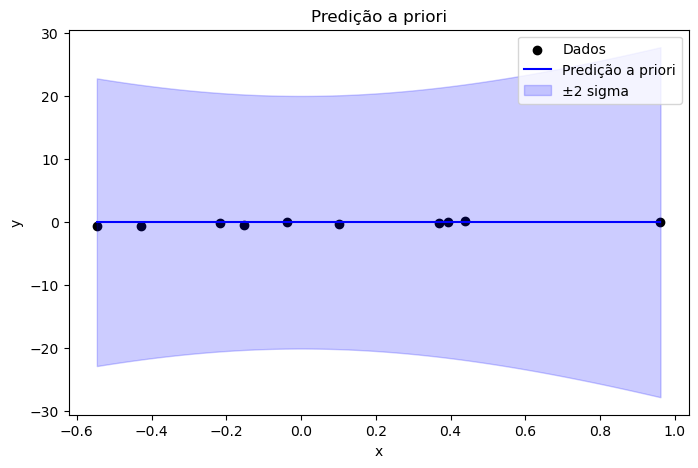

In [115]:

X_test = np.linspace(X_linear_reg.min(), X_linear_reg.max(), 100).reshape(-1, 1)
X_test_bias = np.hstack([np.ones_like(X_test), X_test])

prior_mean = (X_test_bias @ m0).flatten()
prior_var = np.array([float(x.T @ s0 @ x + sigma2) for x in X_test_bias])
prior_std = np.sqrt(prior_var)

plt.figure(figsize=(8,5))
plt.scatter(X_linear_reg, y_linear_reg, color='black', label='Dados')
plt.plot(X_test.flatten(), prior_mean, 'b', label='Predição a priori')
plt.fill_between(
    X_test.flatten(),
    prior_mean - 2 * prior_std,
    prior_mean + 2 * prior_std,
    color='blue', alpha=0.2, label='±2 sigma'
)
plt.legend()
plt.title("Predição a priori")
plt.xlabel("x") 
plt.ylabel("y")
plt.show()


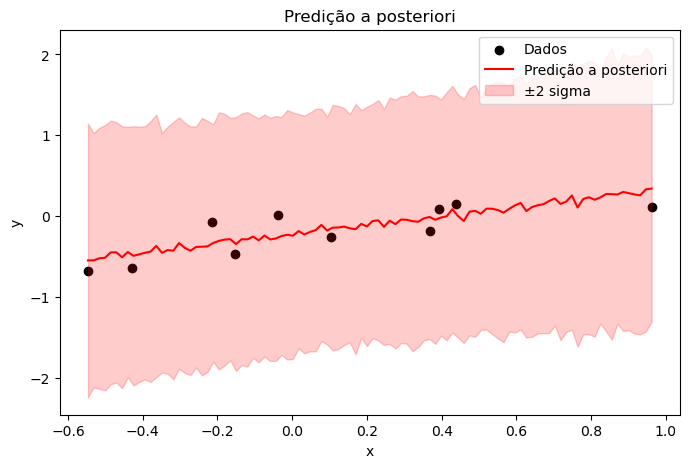

In [116]:
model.estimate(X_bias, y_linear_reg)

pred_samples = [model.predict(X_test_bias) for _ in range(500)]
pred_samples = np.array(pred_samples)

post_mean = np.mean(pred_samples, axis=0).flatten()
post_std = np.std(pred_samples, axis=0).flatten()

plt.figure(figsize=(8,5))
plt.scatter(X_linear_reg, y_linear_reg, color='black', label='Dados')
plt.plot(X_test.flatten(), post_mean, 'r', label='Predição a posteriori')
plt.fill_between(
    X_test.flatten(),
    post_mean - 2 * post_std,
    post_mean + 2 * post_std,
    color='red', alpha=0.2, label='±2 sigma'
)
plt.legend()
plt.title("Predição a posteriori")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Questão 2 - Regressão polinomial

In [117]:
polynomial_data = pd.read_csv("polynomial_regression_data.csv")
X_polynomial = polynomial_data["col1"]
y_polynomial = polynomial_data["col2"]

degree = 5
m0 = np.zeros((degree + 1, 1))
s0 = np.eye(degree + 1) * 1e2
sigma2 = 0.5

model = BayesianPolyReg(sigma2, m0, s0, degree)

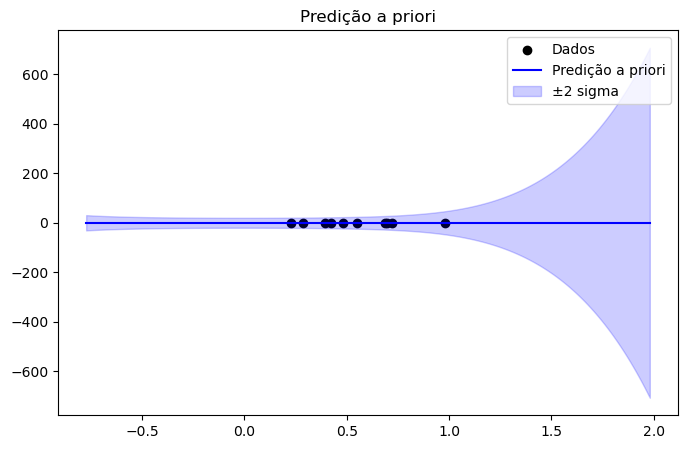

In [118]:
X_test = np.linspace(X_polynomial.min() - 1, X_polynomial.max() + 1, 200)
X_test_df = pd.DataFrame(X_test, columns=["x"])

Phi_ast = model.elevate(X_test_df)
prior_mean = Phi_ast @ model.m0
prior_var = Phi_ast @ model.s0 @ Phi_ast.T + (model.sigma2 * np.eye(len(X_test)))
prior_std = np.sqrt(np.diag(prior_var))

plt.figure(figsize=(8,5))
plt.scatter(X_polynomial, y_polynomial, color='black', label='Dados')
plt.plot(X_test, prior_mean, 'b', label='Predição a priori')
plt.fill_between(
    X_test.flatten(),
    (prior_mean.flatten() - 2 * prior_std),
    (prior_mean.flatten() + 2 * prior_std),
    color='blue', alpha=0.2, label='±2 sigma'
)

plt.legend()
plt.title("Predição a priori")
plt.show()


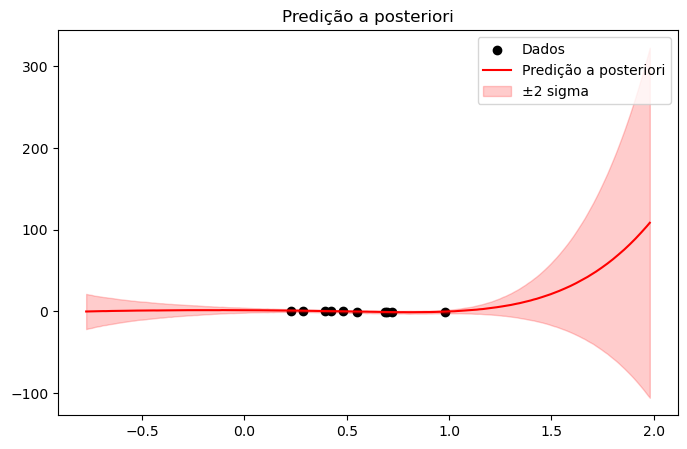

In [119]:
model.estimate(X_polynomial, y_polynomial)

posterior_preds = [model.predict(X_test_df) for _ in range(300)]
posterior_preds = np.array(posterior_preds)
post_mean = posterior_preds.mean(axis=0)
post_std = posterior_preds.std(axis=0)

plt.figure(figsize=(8,5))
plt.scatter(X_polynomial, y_polynomial, color='black', label='Dados')
plt.plot(X_test, post_mean, 'r', label='Predição a posteriori')
plt.fill_between(
    X_test.flatten(),
    (post_mean - 2 * post_std),
    (post_mean + 2 * post_std),
    color='red', alpha=0.2, label='±2 sigma'
)
plt.legend()
plt.title("Predição a posteriori")
plt.show()

### Questão 3 - Regressão logística

/tmp/ipykernel_811/2031324489.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_a = float(self.posteriori_hat.T @ X_ast)
/tmp/ipykernel_811/2031324489.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_a = float(X_ast.T @ np.linalg.inv(self.H) @ X_ast)


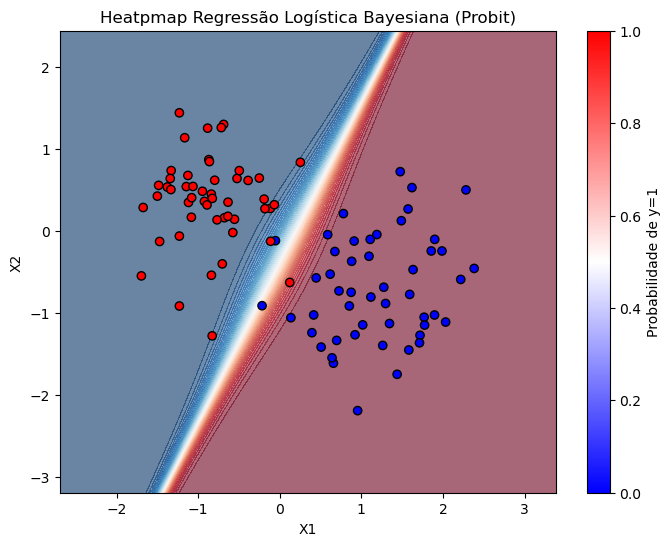

In [120]:
logistic_data = pd.read_csv("logistic_regression_data.csv")

X_logistic = logistic_data.drop(columns= "col3")
y_logistic = logistic_data["col3"]

X_logistic_bias = X_logistic.copy()
X_logistic_bias["bias"] = 1 

d = X_logistic_bias.shape[1]
m0 = np.zeros((d,1))
s0 = np.eye(d) * 1e2
w0 = np.zeros((d,1))

model = BayesianRegLogis(m0=m0, s0=s0, w0=w0)
model.estimate(X_logistic_bias, y_logistic, epochs=100, conv_lim=1e-6)

x_min, x_max = X_logistic.iloc[:,0].min() - 1, X_logistic.iloc[:,0].max() + 1
y_min, y_max = X_logistic.iloc[:,1].min() - 1, X_logistic.iloc[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_bias = np.hstack([grid, np.ones((grid.shape[0],1))]) 

probs = np.array([model.predict(point.reshape(-1,1)) for point in grid_bias])
probs = probs.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
plt.scatter(X_logistic.iloc[:,0], X_logistic.iloc[:,1], c=y_logistic, edgecolor='k', cmap="bwr")
plt.title("Heatpmap Regressão Logística Bayesiana (Probit)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Probabilidade de y=1")
plt.show()